# CNN

In [1]:
%pylab inline
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import h5py
import numpy as np

tile_size = 28

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Import data

In [2]:
h5py
hdf5_path = "scaffan_dataset.hdf5"
# open a hdf5 file and create earrays
hdf5_file = h5py.File(hdf5_path, mode='r')
X = hdf5_file["X"][()]
y = hdf5_file["y"][()]

In [3]:
print(f"X: {X.dtype} {X.shape}, min/max: {(np.min(X), np.max(X))}")
print(f"y: {y.dtype} {y.shape}, unique: {np.unique(y)}")

X: float64 (16938, 28, 28, 1), min/max: (0.14660492152623694, 0.9095808973905876)
y: int32 (16938,), unique: [1 2]


In [4]:
y = to_categorical(y-1)
import sklearn.model_selection
# sklearn.train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

In [5]:
display(np.unique(y_test, return_counts=True))
display(np.unique(y_train, return_counts=True))

(array([0., 1.], dtype=float32), array([5590, 5590], dtype=int64))

(array([0., 1.], dtype=float32), array([11348, 11348], dtype=int64))

In [6]:
y_train.shape


(11348, 2)

## Model

In [7]:

#create model
model = Sequential()
#add model layersfrom keras.models import Sequential
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
# model.add(Dense(10, activation='softmax'))

In [8]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, verbose=2)

Train on 11348 samples, validate on 5590 samples
Epoch 1/3
 - 53s - loss: 0.1145 - acc: 0.9521 - val_loss: 0.0213 - val_acc: 0.9893
Epoch 2/3
 - 50s - loss: 0.0359 - acc: 0.9892 - val_loss: 0.1281 - val_acc: 0.9589
Epoch 3/3
 - 44s - loss: 0.0492 - acc: 0.9857 - val_loss: 0.0066 - val_acc: 0.9993


## Predict

[1. 0.]


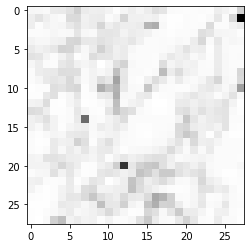

In [10]:
plt.imshow(X_test[-116].reshape(28,28), cmap='gray')
print(y_test[-116])

[0. 1.]


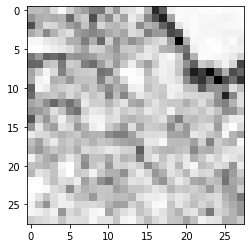

In [11]:
i = -116
plt.imshow(X[i,:,:,0], cmap="gray")
print(y[i])

In [12]:
np.max(np.argmax(model.predict(X_test[:]), axis=1))

1

# Image segmentation 

In [13]:
from pathlib import Path
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0,str(path_to_script))
import scaffan
import scaffan.image as scim
import io3d

pixelsize_mm = [0.004, 0.004]

fn = io3d.datasets.join_path("medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi", get_root=True)
anim = scim.AnnotatedImage(fn)
#
ann_ids = anim.select_annotations_by_color("#000000")
print(ann_ids)
view = anim.get_views(ann_ids, pixelsize_mm=pixelsize_mm)[0]

2019-07-11 07:06:54.224 | DEBUG    | scaffan.image:__init__:166 - Reading file C:\Users\Jirik/data/medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi


add path C:\Users\Jirik\Downloads\openslide-win64-20171122\bin


2019-07-11 07:06:54.235 | DEBUG    | scaffan.image:__init__:180 - Reading the annotation
2019-07-11 07:06:56.230 | DEBUG    | scaffan.annotation:read_annotations:119 - windows annotation output:b'2019-07-11 07:06:56.032 | DEBUG    | scaffan.annotation:ndpa_to_json:71 - PATH: ...\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C...\r\n'


[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


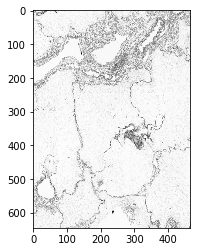

In [14]:
img = view.get_region_image(as_gray=True)
plt.imshow(img, cmap="gray")

In [15]:
seg = np.zeros_like(img, dtype=np.uint8)

In [20]:
for ind0 in range(0, seg.shape[0], tile_size):
    for ind1 in range(0, seg.shape[1], tile_size):
        sl1 = slice(ind0, (ind0+tile_size))
        sl2 = slice(ind1, (ind1+tile_size))
#         print(sl1, sl2)
        img0 = img[sl1,sl2]
        if img0.shape == (tile_size, tile_size):
            img0ok = img0
            pr = model.predict(img0ok.reshape(1,tile_size, tile_size, 1))
            val = np.argmax(pr)
            seg[sl1, sl2] = val
            
        

In [17]:
# img0ok.shape == (tile_size, tile_size)

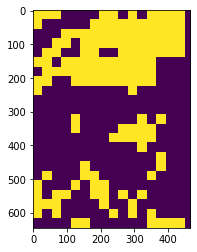

In [18]:
plt.imshow(seg)

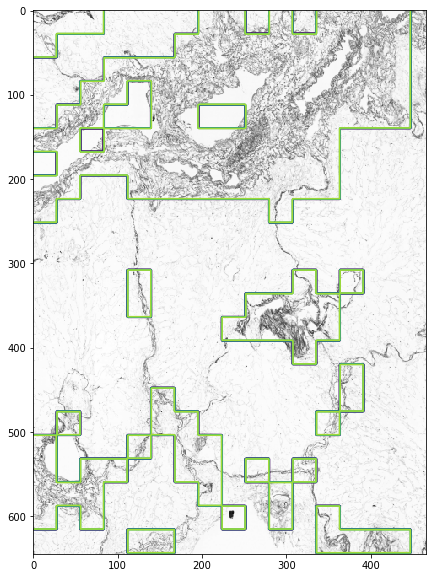

In [19]:
plt.figure(figsize(10,10))
plt.imshow(img, cmap="gray")
plt.contour(seg)
# plt.imshwo(im)